# Back-calculating SWE using the surface energy balance
Danny Hogan

3/8/2024

In [1]:
from metloom.pointdata import SnotelPointData
from metloom.variables import SnotelVariables
import datetime as dt
import numpy as np
import pandas as pd
import os
from metpy import calc
from metpy.units import units
import matplotlib.pyplot as plt

# Download SNOTEL data

In [2]:
# start 
start = "2005-10-01"
# end
end = "2010-09-30"
# north cascades data
n_cascades = SnotelPointData(station_id="515:WA:SNTL", name='Harts Pass')
n_cascades_df = n_cascades.get_daily_data(start, end, 
                                          [n_cascades.ALLOWED_VARIABLES.SWE,
                                           n_cascades.ALLOWED_VARIABLES.PRECIPITATION])

# central utah data
c_utah = SnotelPointData(station_id="766:UT:SNTL", name='Snowbird')
c_utah_df = c_utah.get_daily_data(start, end,
                                    [c_utah.ALLOWED_VARIABLES.SWE,
                                     c_utah.ALLOWED_VARIABLES.PRECIPITATION])

# northern sierra nevada
n_sierra = SnotelPointData(station_id="539:CA:SNTL", name='Independence Camp')
n_sierra_df = n_sierra.get_daily_data(start, end,
                                    [n_sierra.ALLOWED_VARIABLES.SWE,
                                     n_sierra.ALLOWED_VARIABLES.PRECIPITATION])

### Convert to mm

In [3]:
# convert to mm
n_cascades_df['SWE'] = n_cascades_df['SWE'] * 25.4
c_utah_df['SWE'] = c_utah_df['SWE'] * 25.4
n_sierra_df['SWE'] = n_sierra_df['SWE'] * 25.4

# convert precipitation to inches
n_cascades_df['PRECIPITATION'] = n_cascades_df['PRECIPITATION'] * 25.4
c_utah_df['PRECIPITATION'] = c_utah_df['PRECIPITATION'] * 25.4
n_sierra_df['PRECIPITATION'] = n_sierra_df['PRECIPITATION'] * 25.4

# reset index and make it the datetime column
n_cascades_df = n_cascades_df.reset_index()
c_utah_df = c_utah_df.reset_index()
n_sierra_df = n_sierra_df.reset_index()



# Pull in Daymet data
Assumptions using daymet observations. Downloaded from https://daymet.ornl.gov/single-pixel/

In [4]:
n_cascades_daymet = pd.read_csv('./data/daymet/harts_pass_daymet_20051001_20100930.csv', skiprows=[0,1,2,3,4,5,6])
c_utah_daymet = pd.read_csv('./data/daymet/snowbird_daymet_20051001_20100930.csv', skiprows=[0,1,2,3,4,5,6])
n_sierra_daymet = pd.read_csv('./data/daymet/independence_camp_daymet_20051001_20100930.csv', skiprows=[0,1,2,3,4,5,6])

Add day of water year to the SNOTEL dataset

In [5]:
# convert year and yday to date
n_cascades_daymet['Date'] = n_cascades_daymet.apply(lambda row: dt.datetime(int(row['year']), 1, 1) + dt.timedelta(int(row['yday']) - 1), axis=1)
c_utah_daymet['Date'] = c_utah_daymet.apply(lambda row: dt.datetime(int(row['year']), 1, 1) + dt.timedelta(int(row['yday']) - 1), axis=1)
n_sierra_daymet['Date'] = n_sierra_daymet.apply(lambda row: dt.datetime(int(row['year']), 1, 1) + dt.timedelta(int(row['yday']) - 1), axis=1)
# add a dowy column
def dowy(date):
    if date.day_of_year < 274:
        if date.year % 4 == 0:
            return date.day_of_year + 93
        else:
            return date.day_of_year + 92
    else:
        if date.year % 4 == 0:
            return date.day_of_year - 274 
        else:
            return date.day_of_year - 273
n_cascades_daymet['dowy'] = n_cascades_daymet['Date'].apply(dowy)
c_utah_daymet['dowy'] = c_utah_daymet['Date'].apply(dowy)
n_sierra_daymet['dowy'] = n_sierra_daymet['Date'].apply(dowy)

Calculate average temperature

In [6]:
n_cascades_daymet['tavg'] = (n_cascades_daymet['tmax (deg c)'] + n_cascades_daymet['tmin (deg c)']) / 2
c_utah_daymet['tavg'] = (c_utah_daymet['tmax (deg c)'] + c_utah_daymet['tmin (deg c)']) / 2
n_sierra_daymet['tavg'] = (n_sierra_daymet['tmax (deg c)'] + n_sierra_daymet['tmin (deg c)']) / 2

Add day of water year and water year to the Daymet dataset

In [9]:
# add a doy of water year column
n_cascades_df['dowy'] = n_cascades_df['datetime'].apply(dowy)
c_utah_df['dowy'] = c_utah_df['datetime'].apply(dowy)
n_sierra_df['dowy'] = n_sierra_df['datetime'].apply(dowy)
# add a water year column
n_cascades_df['water_year'] = n_cascades_df['datetime'].apply(lambda date: date.year if date.month < 10 else date.year + 1)
c_utah_df['water_year'] = c_utah_df['datetime'].apply(lambda date: date.year if date.month < 10 else date.year + 1)
n_sierra_df['water_year'] = n_sierra_df['datetime'].apply(lambda date: date.year if date.month < 10 else date.year + 1)

Calculate days before melt for each site

In [193]:
# for each year, identify the first day after dowy 92 that has 0 SWE
# then calculate the days before and after that date

for i, year in enumerate(n_cascades_df['water_year'].unique()):
    year_df = n_cascades_df[n_cascades_df['water_year'] == year]
    year_df = year_df[year_df['dowy'] > 92]
    snow_dissapearance = year_df['SWE'].idxmin()
    if year_df.empty:
        continue
    else:
        n_cascades_df.loc[(n_cascades_df['water_year'] == year) & (n_cascades_df['dowy'] < year_df.iloc[0]['dowy']), 'before_melt'] = -(n_cascades_df['dowy'] - year_df.loc[snow_dissapearance]['dowy'])
        n_cascades_df.loc[(n_cascades_df['water_year'] == year) & (n_cascades_df['dowy'] >= year_df.iloc[0]['dowy']), 'after_melt'] = -(n_cascades_df['dowy'] - year_df.loc[snow_dissapearance]['dowy'])
        # merge the two columns
        n_cascades_df['days_until_meltout'] = n_cascades_df['before_melt'].combine_first(n_cascades_df['after_melt'])


In [194]:
for i, year in enumerate(c_utah_df['water_year'].unique()):
    year_df = c_utah_df[c_utah_df['water_year'] == year]
    year_df = year_df[year_df['dowy'] > 92]
    snow_dissapearance = year_df['SWE'].idxmin()
    if year_df.empty:
        continue
    else:
        c_utah_df.loc[(c_utah_df['water_year'] == year) & (c_utah_df['dowy'] < year_df.iloc[0]['dowy']), 'before_melt'] = -(c_utah_df['dowy'] - year_df.loc[snow_dissapearance]['dowy'])
        c_utah_df.loc[(c_utah_df['water_year'] == year) & (c_utah_df['dowy'] >= year_df.iloc[0]['dowy']), 'after_melt'] = -(c_utah_df['dowy'] - year_df.loc[snow_dissapearance]['dowy'])
        # merge the two columns
        c_utah_df['days_until_meltout'] = c_utah_df['before_melt'].combine_first(c_utah_df['after_melt'])

In [196]:
for i, year in enumerate(n_sierra_df['water_year'].unique()):
    year_df = n_sierra_df[n_sierra_df['water_year'] == year]
    year_df = year_df[year_df['dowy'] > 92]
    snow_dissapearance = year_df['SWE'].idxmin()
    if year_df.empty:
        continue
    else:
        n_sierra_df.loc[(n_sierra_df['water_year'] == year) & (n_sierra_df['dowy'] < year_df.iloc[0]['dowy']), 'before_melt'] = -(n_sierra_df['dowy'] - year_df.loc[snow_dissapearance]['dowy'])
        n_sierra_df.loc[(n_sierra_df['water_year'] == year) & (n_sierra_df['dowy'] >= year_df.iloc[0]['dowy']), 'after_melt'] = -(n_sierra_df['dowy'] - year_df.loc[snow_dissapearance]['dowy'])
        # merge the two columns
        n_sierra_df['days_until_meltout'] = n_sierra_df['before_melt'].combine_first(n_sierra_df['after_melt'])

### Albedo decay function

**Note**: Albedo max and min are change to 0.6 and 0.2 for the albedo impact part of the question

In [199]:
# develop simple snow melt model to estimate potential melt
# assume all net radiation goes towards melting snow
# assume snow surface temperature is 0C always
# sky view fraction. Assume 1.0 


albedo_min = 0.5
albedo_max = 0.9
landsurf_albedo = 0.2
def albedo_decay(df):
    # fill a with 0.2
    a = np.full(df['swe (kg/m^2)'].shape, landsurf_albedo)
    for i, snow in enumerate(df['swe (kg/m^2)']):
        if i == 0:
            previous_snow = 0
        else:
            previous_snow = df['swe (kg/m^2)'].iloc[i-1]
        if snow == 0:
            a[i] = landsurf_albedo
        # if the difference between the previous day and the current day is greater than or equal to 0
        elif (snow - previous_snow) > 0:
            # increase albedo to 0.9
            a[i] = albedo_max
        else:
            # decrease albedo towards 0.6 using decay rate of 16 days
            a[i] = albedo_min + (a[i-1] - albedo_min) * np.exp(-(1)/16)
    return a

# add albedo to the dataframes
n_cascades_daymet['albedo'] = albedo_decay(n_cascades_daymet)
c_utah_daymet['albedo'] = albedo_decay(c_utah_daymet)
n_sierra_daymet['albedo'] = albedo_decay(n_sierra_daymet)

Text(0.5, 0, 'Day of Water Year')

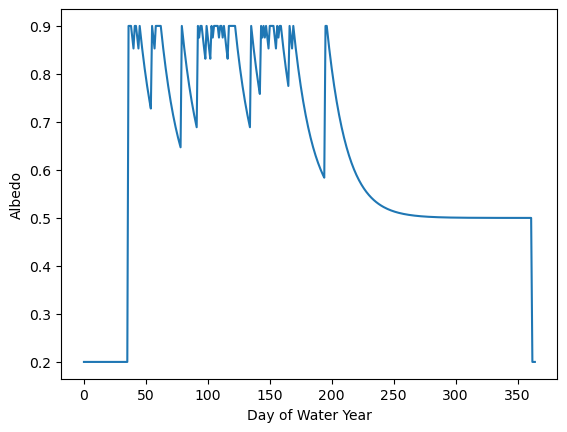

In [200]:
n_cascades_daymet['albedo'].iloc[0:365].plot()
plt.ylabel('Albedo')
plt.xlabel('Day of Water Year')

Add days until meltout to the dataset

In [201]:
n_cascades_daymet['days_until_meltout'] = n_cascades_df['days_until_meltout']
c_utah_daymet['days_until_meltout'] = c_utah_df['days_until_meltout']   
n_sierra_daymet['days_until_meltout'] = n_sierra_df['days_until_meltout']
# add a water_year column
n_cascades_daymet['water_year'] = n_cascades_daymet['Date'].apply(lambda date: date.year if date.month < 10 else date.year + 1)
c_utah_daymet['water_year'] = c_utah_daymet['Date'].apply(lambda date: date.year if date.month < 10 else date.year + 1)
n_sierra_daymet['water_year'] = n_sierra_daymet['Date'].apply(lambda date: date.year if date.month < 10 else date.year + 1)

Find start of the snow season (when SWE is > 0)

In [202]:
# for each water year find the date where SWE is first greater than 0
for wy in n_cascades_daymet.water_year.unique():
    first_swe = n_cascades_df[(n_cascades_df['water_year'] == wy) & (n_cascades_df['SWE'] > 0)].dowy.min()
    n_cascades_daymet.loc[n_cascades_daymet['water_year'] == wy, 'first_swe'] = first_swe
    # calculate the cumulative precip between first swe and melt out
    cum_precip = n_cascades_daymet[(n_cascades_daymet['water_year'] == wy) & (n_cascades_daymet['dowy'] >= first_swe) & (n_cascades_daymet['days_until_meltout'] > 0)]['prcp (mm/day)'].cumsum()
    

# Calculate potential melt for a single day

In [203]:
def potential_melt(water_year, days_until_meltout, snow_df , daymet_df):
    if days_until_meltout < 0:
        return 0
    
    else:
        # elevation
        Z = snow_df.geometry.z.iloc[0]/3.21
        # calculate the average temperature
        tmp_df = daymet_df[(daymet_df['water_year'] == water_year) & (daymet_df['days_until_meltout'] == days_until_meltout)]
        if tmp_df.dowy.values[0] < 61:
            return 0 - tmp_df['prcp (mm/day)'].values[0]
        else:
            # calculate vapor pressure
            vapor_pressure = (tmp_df['vp (Pa)'].values)*units('pascal')
            # calculate saturation vapor pressure
            sat_vapor_pressure = calc.saturation_vapor_pressure(tmp_df['tavg'].values*units('degC'))
            # calculate relative humidity
            RH = vapor_pressure/ sat_vapor_pressure
            # estimate pressure
            P = 101.3 * ((( 293 - ( 0.0065 * (Z) )) / 293 )**5.26 )
            # create array with P of the same length as the vapor pressure
            P = np.full(vapor_pressure.shape, P) * units('hPa')
            # calculate dew point temperature from RH
            Td = calc.dewpoint_from_relative_humidity(tmp_df['tavg'].values*units('degC'), RH)
            # calculate net longwave from air temperature and dew point temperature following Marks and Dozier (1979)
            T_prime = ((vapor_pressure.magnitude) + 273.15) + (0.0065*Z)
            # assume emissitivity of air is 0.741 + 0.0062*Td from Berdahl and Fomberg (1982)
            emissivity_air = (0.741 + 0.0062*Td.magnitude)
            # assume emissitivity of snow is 0.98
            emissivity_surf = 0.98

            # calculate net longwave
            Vf = 1.0 # view factor assumed to be 1
            LWd = (emissivity_air * 5.67e-8 * (tmp_df['tavg'].values + 273.15)**4)*(Vf) - (emissivity_surf * 5.67e-8 * (Td.magnitude + 273.15)**4)*(1-Vf)
            LWu = (emissivity_surf * 5.67e-8 * (Td.magnitude + 273.15)**4)
            # get albedo
            a = tmp_df['albedo']
            # get_daylight fraction
            daylight_fraction = tmp_df['dayl (s)'].values[0]/86400
            # calculate net shortwave
            net_sw = (daylight_fraction*(tmp_df['srad (W/m^2)'] - (a*tmp_df['srad (W/m^2)'])))
            # normalize by the day fraction
            net_sw = net_sw  * daylight_fraction
            # calculate net radiation
            Rn = net_sw + (LWd - LWu)
            # convert W/m^2 to mm of water using the latent heat of melting
            Lm = 334
            # assume no melt on cold days
            if tmp_df['tavg'].values[0] < 0:
                return 0 #- tmp_df['prcp (mm/day)'].values[0]
            # assume no melt on Rnet < 0 days
            elif Rn.values[0] < 0:
                return 0 #- tmp_df['prcp (mm/day)'].values[0]
            else:
                potential_melt = ((Rn) / (Lm)) * 86400 / 1000 # - tmp_df['prcp (mm/day)']
                return potential_melt.values[0]

### Calculate cumulative melt to derive Max SWE magnitude and timing

In [204]:
def calculate_projected_max_swe(df_daymet, df_sntl, water_year):
    df = df_daymet[df_daymet['water_year'] == water_year]
    # sort by days until meltout
    df = df.sort_values(by='days_until_meltout')
    # remove negative values
    df = df[df['days_until_meltout'] >= 0]
    # sort from earliest to latest
    df = df.sort_values(by='days_until_meltout', ascending=True)
    # cumulative sum of potential melt
    pot_melt = np.zeros(df.shape[0])
    # cumulative sum of precip 
    precip = np.zeros(df.shape[0])
    for i,d in enumerate(df['days_until_meltout']):
        # if d
        pot_melt[i]=potential_melt(water_year, d, df_sntl, df_daymet)
        # precip[i] = df[df['days_until_meltout']==d]['prcp (mm/day)']
    # identify the local first local maximum of cumalative potential melt

    max_pot_melt_date = np.argmax(pot_melt.cumsum())
    # return the date of the local maximum
    max_pot_melt_value = (pot_melt.cumsum())[max_pot_melt_date]

    # convert to actual max date
    max_swe_date = df_sntl[(df_sntl['water_year']==water_year) & (df_sntl['days_until_meltout']==max_pot_melt_date)]['dowy'].values[0]
    return ([max_swe_date, max_pot_melt_value])

def calculate_actual_max_swe(df_sntl,water_year):
    actual_max_date = df_sntl[(df_sntl['water_year']==water_year) & (df_sntl['SWE']==df_sntl[df_sntl['water_year']==water_year]['SWE'].max())]['dowy'].values[0]
    actual_max_value = df_sntl[(df_sntl['water_year']==water_year) & (df_sntl['SWE']==df_sntl[df_sntl['water_year']==water_year]['SWE'].max())]['SWE'].values[0]
    return ([actual_max_date, actual_max_value])

### Get model results for all sites and all years

In [205]:
model_results = pd.DataFrame(columns=['year','location','projected_max_date', 'projected_max_value', 'actual_max_date', 'actual_max_value'],
                              index=range(0,15))
locations = {
    'Harts Pass - North Cascades': [n_cascades_daymet, n_cascades_df],
    'Snowbird - Central Utah': [c_utah_daymet, c_utah_df],
    'Independence Camp - North Sierra': [n_sierra_daymet, n_sierra_df]
}
i = 0
for location in locations.keys():
    for year in [2006, 2007, 2008, 2009, 2010]:
        projected_max = calculate_projected_max_swe(locations[location][0], locations[location][1], year)
        actual_max = calculate_actual_max_swe(locations[location][1], year)
        model_results.iloc[i] = [year, location, projected_max[0], projected_max[1], actual_max[0], actual_max[1]]
        i+=1


### Plot results

Harts Pass - North Cascades 35.88887942359023
Snowbird - Central Utah 72.36390787773024
Independence Camp - North Sierra 63.21695285693549
Harts Pass - North Cascades 15.6
Snowbird - Central Utah 13.6
Independence Camp - North Sierra 10.8


Text(0.5, 1.0, 'Date of Peak SWE  (DOWY)')

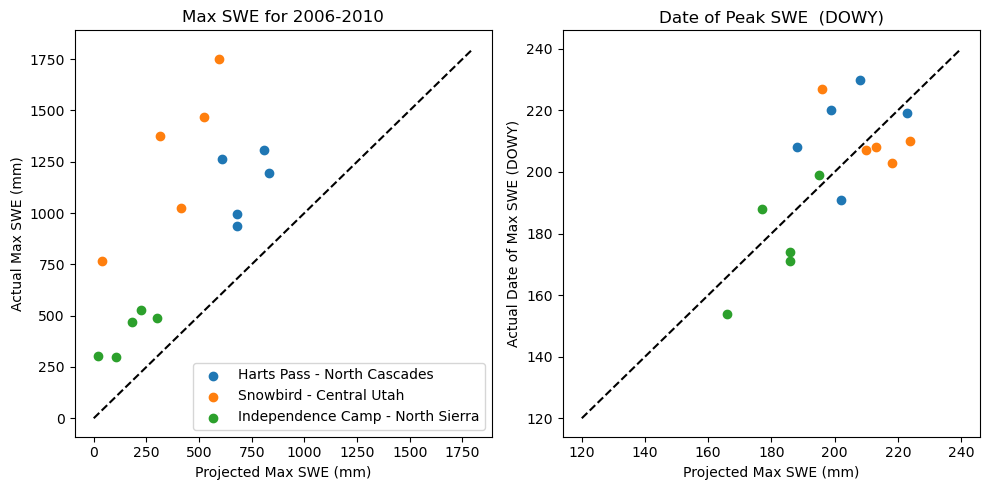

In [206]:
# for each location, calculate the difference between the projected and actual max swe
fig, axs = plt.subplots(1,2, figsize=(10,5), tight_layout=True)
ax = axs[0]
for site in model_results.location.unique():
    site_df = model_results[model_results['location'] == site]
    # print the mean absolute percentage error
    print(site, np.mean(np.abs((site_df['projected_max_value'] - site_df['actual_max_value'])/site_df['actual_max_value'])*100))
    ax.scatter(site_df['projected_max_value'],  site_df['actual_max_value'], label=site)
# add 1:1 line
ax.plot([0, 1800], [0, 1800], 'k--')
# ax.set_xlim(0, 1800)
# ax.set_ylim(0, 1800)
ax.set_xlabel('Projected Max SWE (mm)')
ax.set_ylabel('Actual Max SWE (mm)')
# add legend in bottom right
ax.legend(loc='lower right')
ax.set_title('Max SWE for 2006-2010')

ax = axs[1]
for site in model_results.location.unique():
    site_df = model_results[model_results['location'] == site]
    # print the mean absolute error
    print(site, np.mean(np.abs(site_df['projected_max_date'] - site_df['actual_max_date'])))
    ax.scatter(site_df['projected_max_date'],  site_df['actual_max_date'], label=site)
# add 1:1 line
ax.plot([120, 240], [120, 240], 'k--')
# ax.set_xlim(160, 240)
# ax.set_ylim(160, 240)
ax.set_xlabel('Projected Max SWE (mm)')
ax.set_ylabel('Actual Date of Max SWE (DOWY)')
ax.set_title('Date of Peak SWE  (DOWY)')

### Plot a single year at a single site as an example

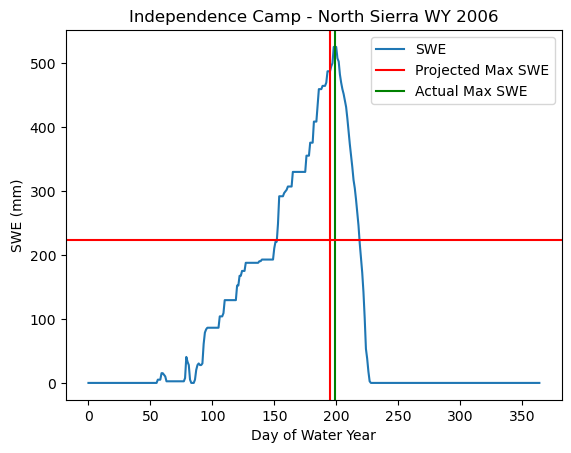

In [ ]:
n_sierra_df[n_sierra_df['water_year'] == 2006]['SWE'].plot()
# plot the dowy of max swe
plt.axvline(x=model_results[(model_results['year'] == 2006)&
                            (model_results['location']=='Independence Camp - North Sierra')]['projected_max_date'].values[0], color='r', label='Projected Max SWE')
plt.axvline(x=model_results[(model_results['year'] == 2006)&
                            (model_results['location']=='Independence Camp - North Sierra')]['actual_max_date'].values[0], color='g', label='Actual Max SWE')
# plot projected max swe
plt.axhline(y=model_results[(model_results['year'] == 2006)&
                            (model_results['location']=='Independence Camp - North Sierra')]['projected_max_value'].values[0], color='r')
plt.xlabel('Day of Water Year')
plt.ylabel('SWE (mm)')
plt.title('Independence Camp - North Sierra WY 2006')
plt.legend()

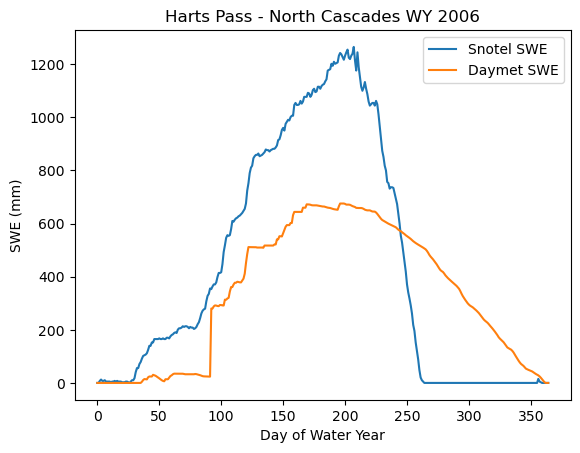

In [217]:
n_cascades_df[n_cascades_df['water_year'] == 2006]['SWE'].plot(label='Snotel SWE')
# plot daymet snow
n_cascades_daymet[n_cascades_daymet['water_year'] == 2006]['swe (kg/m^2)'].plot(label='Daymet SWE')
# plot the dowy of max swe for each
# plt.axvline(x=n_cascades_df[(n_cascades_df['water_year'] == 2006)]['SWE'].idxmax(), color='r', label='Projected Max SWE')
# plt.axvline(x=n_cascades_daymet[(n_cascades_daymet['water_year'] == 2006)]['swe (kg/m^2)'].idxmax(), color='r', label='Projected Max SWE')
plt.xlabel('Day of Water Year')
plt.ylabel('SWE (mm)')
plt.title('Harts Pass - North Cascades WY 2006')
plt.legend()

### Plot some comparisons of the locations
- Pearson's correlation of SWE
- SWE comparison
- Temperature comparison

In [207]:
print(np.corrcoef(n_cascades_df['SWE'],c_utah_df['SWE']))
print(np.corrcoef(n_cascades_df['SWE'],n_sierra_df['SWE']))
print(np.corrcoef(c_utah_df['SWE'],n_sierra_df['SWE']))

[[1.         0.84381733]
 [0.84381733 1.        ]]
[[1.         0.68305634]
 [0.68305634 1.        ]]
[[1.         0.71432061]
 [0.71432061 1.        ]]


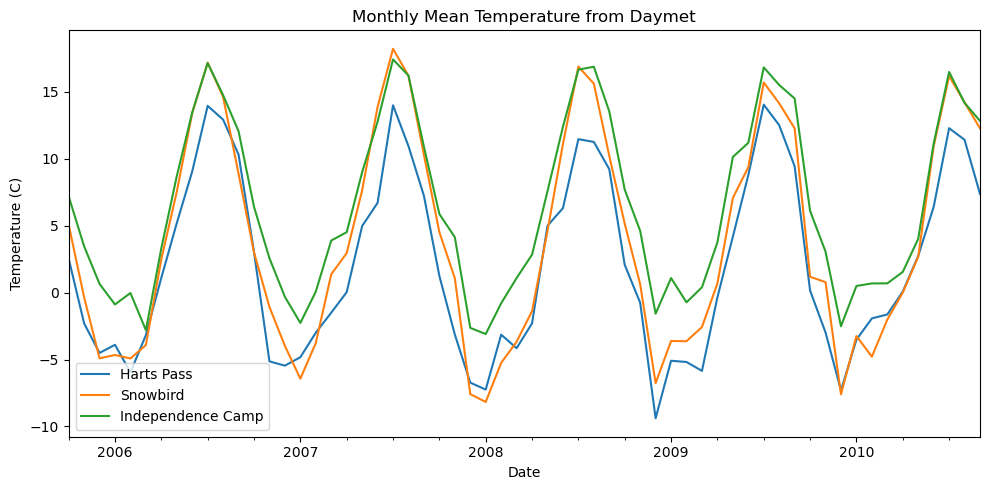

In [208]:
# plot the daymet temperature time series
fig, ax = plt.subplots(1,1,figsize=(10,5), tight_layout=True)
# resample to monthly mean temperatuer
n_cascades_daymet.set_index('Date').tavg.resample('M').mean().plot(ax=ax, label='Harts Pass')
c_utah_daymet.set_index('Date').tavg.resample('M').mean().plot(ax=ax, label='Snowbird')
n_sierra_daymet.set_index('Date').tavg.resample('M').mean().plot(ax=ax, label='Independence Camp')

ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Date')
ax.set_title('Monthly Mean Temperature from Daymet')
ax.legend()



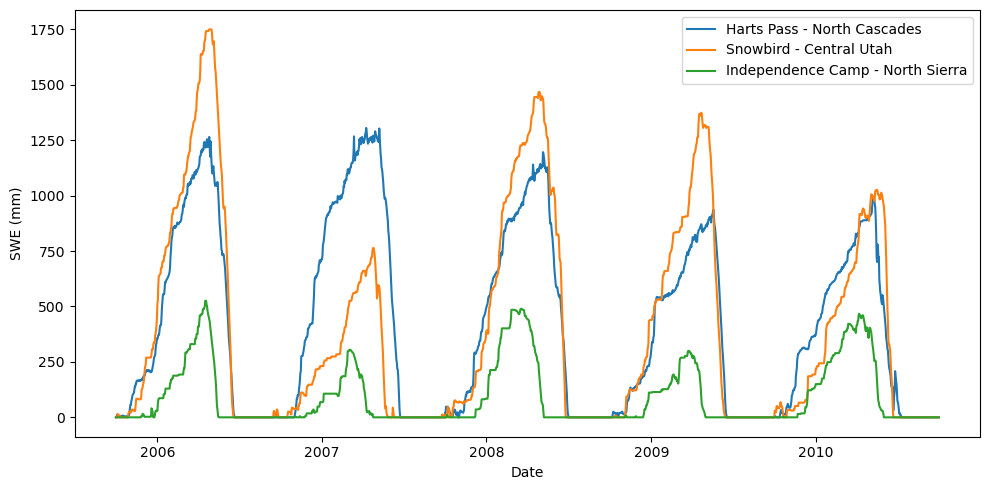

In [209]:
# plot all three locations
fig, ax = plt.subplots(1,1, figsize=(10,5), tight_layout=True)

ax.plot(n_cascades_df['datetime'], n_cascades_df['SWE'], label='Harts Pass - North Cascades')
ax.plot(c_utah_df['datetime'], c_utah_df['SWE'], label='Snowbird - Central Utah')
ax.plot(n_sierra_df['datetime'], n_sierra_df['SWE'], label='Independence Camp - North Sierra')
ax.set_ylabel('SWE (mm)')
ax.set_xlabel('Date')
ax.legend()